In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def logprior(b, sigma2):
    #flat prior
    return -np.log(sigma2)
    #conjugate prior??
    #return - b[0]**2*2 - b[1]1**2*2 - 2.0*np.log(sigma2) - 0.5/sigma2
    
def logistic(x, b):
    #x[0]: t
    #x[1]: h
    #x[2]: w
    theta = b[0] + x[0]*b[1] + x[1]*b[2] + x[2]*b[3]
    return 1.0/(1+np.exp(theta))

def loglikelihood(b, sigma2, x, y):
    n = len(x)
    return -n*np.log(sigma2) - 0.5*((y-logistic(x, b))**2).sum()/sigma2

def logpost(b, sigma2, x, y):
    return logprior(b, sigma2) + loglikelihood(b, sigma2, x, y)

In [117]:
# mcmc algorithm
def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e):
    B = np.zeros((N,len(b_init)))
    Sig2 = np.zeros(N)
    
    b_prev = b_init
    sig2_prev = sig2
    count = 0
    r = np.random.random(N)
    
    for i in xrange(N):
        b_star = np.random.normal(b_prev,be)

        sig2_star = abs(np.random.normal(sig2_prev, sig2e))
        
        p = logpost(b_star, sig2_star, x, y) - logpost(b_prev, sig2_prev, x, y)
        if np.log(r[i]) < p:
            b_prev = b_star
            sig2_prev = sig2_star
            count += 1
                           
        B[i] = b_prev
        Sig2[i] = sig2_prev
    print "The acceptance rate is "+ str(float(count)/N)+"."
    #return B, Sig2
    return np.vstack((B[:,0],B[:,1],B[:,2],B[:,3],Sig2[burnin:]))

In [6]:
#import data and labels
train_data = pd.read_csv('Waterpump-training-values.csv')
train_labels = pd.read_csv('Waterpump-training-labels.csv')

#separating dataset into training and testing for cross-validation
np.random.seed(142)
test_idx = np.random.uniform(0, 1, len(train_data)) <= 0.7
train = train_data[test_idx==True]
trainLabels = train_labels[test_idx==True]
test = train_data[test_idx==False]
testLabels = train_labels[test_idx==False]


I would want to get rid of all rows missing any of the data before running the sampler.

In [7]:
train = train[train['longitude'] > 1]
train = train[train['latitude'] < 0]
train = train[train['construction_year'] != 0]
train = train[train['gps_height'] != 0]


features = ['longitude','latitude']
trainLoc = train[features]
#hasLocIdx = train['longitude']>1
#trainLoc = trainLoc[hasLocIdx] #remove rows with empty location data
#trainLoc.head()
#hasLocIdx.head()

trainID = train['id']
trainLabelsLoc = trainLabels[trainLabels['id'].isin(trainID)] #only keep labels corresponding to rows with non-empty location data


In [8]:
nNeighbors = 60
clf = KNeighborsClassifier(n_neighbors=nNeighbors,weights='distance',algorithm='auto')
clf.fit(trainLoc[features], trainLabelsLoc['status_group'])
#preds = clf.predict(test[features])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=60, p=2, weights='distance')

In [9]:
features=['construction_year', 'gps_height']
trainFeatures = train[features]
trainFeatures['age'] = 2015 - trainFeatures['construction_year']
trainFeatures = trainFeatures.drop('construction_year', 1)
#trainFeatures.head()

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [10]:
kNNFunctional = clf.predict_proba(trainFeatures)[:,0]
#TODO: get more meaningful data out of kNN algorithm?
x = np.vstack((trainFeatures['age'],trainFeatures['gps_height'],kNNFunctional))

In [11]:
trainLabels = trainLabels[trainLabels['id'].isin(trainID)] #get rid of Labels for which there is no corresponding data

numFeatures = 3
numBeta = numFeatures + 1  #1 more for the constant
#TODO: Convert labels into numbers
trainLabelsVect = pd.get_dummies(trainLabels['status_group'])
trainLabelsVect['functionality'] = trainLabelsVect['functional'] + 0.5*trainLabelsVect['functional needs repair']

#B, sig2= mcmc(np.zeros(numBeta), 0.2, x, trainLabelsVect['functionality'], 100, 0, 0.5, 0.5)

In [12]:
B, sig2= mcmc(np.zeros(numBeta), 0.2, x, trainLabelsVect['functionality'], 10000, 0, 0.1, 0.1)

The acceptance rate is 0.0042.


0.0557293894857


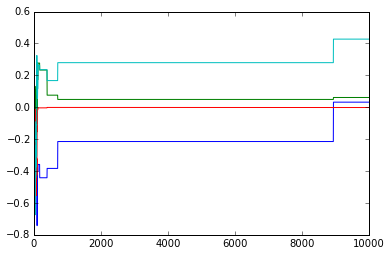

In [238]:
plt.plot(B[:,0])
plt.plot(B[:,1])
plt.plot(B[:,2])
plt.plot(B[:,3])
print np.mean(B[:,1])

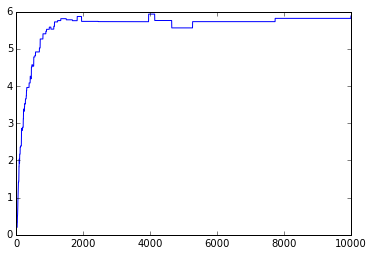

In [121]:
plt.plot(sig2)

Do Geweke Test to see if trace has converged. Burn-in looks to be around 2000.

In [103]:
# autocorrelation with lag t
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Geweke function
def Geweke(trace, intervals, length):
    # take two parts of the chain. 
    # subsample lenght 
    nsl=length
    jump = int(0.9*len(trace)/(2*intervals))
    first = 0.1*len(trace)
    z =np.empty(intervals)
    for k in np.arange(0, intervals):
        # beg of each sub samples
        bega=first+k*jump
        begb = len(trace)/2 + k*jump
        
        sub_trace_a = trace[bega:bega+nsl]
        sub_trace_b = trace[begb:begb+nsl]
        
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # only compute autocorrelation at lag 1-0.1*nsl.
        for i in xrange(int(0.1*nsl)):
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # estimate the variance roughly
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z



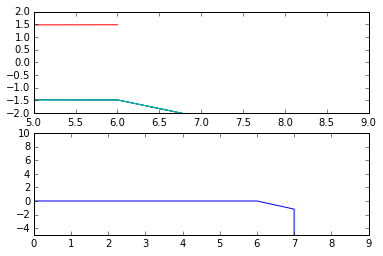

In [240]:
burnin = 2000
gewekeB0 = Geweke(B[burnin:,0], 10, 5000)
gewekeB1 = Geweke(B[burnin:,1], 10, 5000)
gewekeB2 = Geweke(B[burnin:,2], 10, 5000)
gewekeB3 = Geweke(B[burnin:,3], 10, 5000)
gewekesig2 = Geweke(sig2[3000:], 10, 300)

plt.figure(1)
plt.subplot(211)
plt.plot(gewekeB0)
plt.plot(gewekeB1)
plt.plot(gewekeB2)
plt.plot(gewekeB3)
plt.ylim((-2,2))

plt.subplot(212)
plt.plot(gewekesig2)
plt.ylim((-5,10))
plt.show()

Make predictions:

In [162]:
# show posterior mean and variance
def post_ana(res):
    mean = res.mean(axis = 1)
    sd = np.zeros(4)
    sd[0] = np.std(res[:, 0])
    sd[1] = np.std(res[:, 1])
    sd[2] = np.std(res[:, 2])
    sd[3] = np.std(res[:, 3])
    print "The posterior mean and standard deviation for beta0 are "+str(mean[0])+" and "+str(sd[0])+"."
    print "The posterior mean and standard deviation for beta are "+str(mean[1])+" and "+str(sd[1])+"."
    print "The posterior mean and standard deviation for sigma2 are "+str(mean[2])+" and "+str(sd[2])+"."

# compute the predictive intervals at each x 
def predict(res, x, y, m):
    n = len(x)
    print "n: ", n
    print "x.shape: ", (x.shape)
    x = x.reshape((n,1))
    print "x.shape: ", (x.shape)

    count = 0
    #print "res shape: ",res[:10]
    print "res.shape: ", (res.shape)
    #res = res.reshape((m,5))
    #print "res.shape: ", (res.shape)

    #Result = np.zeros((n, res.shape[1]*m))
    Result = np.zeros((n,(res.shape[1]*m)))
    print "Result: ", Result.shape
    #print "res[2,0]: ", res[3,0]
    
    for i in xrange(res.shape[1]):
        Result[:,(i*m):(i*m+m)] = np.random.normal(scale = 0.001, size=m*n).reshape((n,m)) + np.repeat(res[0,i]+res[1,i]*x,m, axis=1)
        #Result[3,(i*m):(i*m+m)] = np.random.normal(scale = 0.001, size=m*n).reshape((n,m)) + np.repeat(res[0,i]+res[1,i]*x,m, axis=1)

    bounds = np.zeros((n,2))
    for i in xrange(n):
        bounds[i,:] = np.percentile(Result[i,:], [2.5,97.5])
        if y[i] < bounds[i,1] and y[i] > bounds[i,0]:
            count += 1
    print "There are "+str(count) +" yis out of "+str(n) +" that falls in the predictive interval."
    return bounds

In [130]:
b = x[0,:]

c = np.vstack(b)
print c.shape 
#(2,3)
print B[:10,2]

(26563, 1)
[ 0.         0.         0.         0.         0.         0.         0.         0.
  0.        -0.0276128]


In [118]:
#def mcmc(b_init, sig2, x, y, N, burnin, be, sig2e):


res_gaussian_flat = mcmc(np.zeros(numBeta), 0.2, x, trainLabelsVect['functionality'], 10000, 0, 0.1, 0.1)
#bounds_gaussian_flat = predict(B[:,2], c, trainLabelsVect['functionality'], 26563)
#np.zeros(numBeta), 0.2, x, ,
#post_ana(res_gaussian_flat)

The acceptance rate is 0.0121.


In [166]:
#get rid of extra columns just to see if I can make the data fit the same format as the original code from HW7 and just get it working
elim = [3,4]
np.delete(res_gaussian_flat, elim)

array([ 0.        ,  0.        ,  0.        , ...,  7.77026562,
        7.77026562,  7.77026562])

In [167]:
bounds_gaussian_flat = predict(res_gaussian_flat, x[0,:], trainLabelsVect['functionality'], 100)

#bounds_gaussian_flat = predict(res_gaussian_flat, x, y, m, "gaussian") 



n:  26563
x.shape:  (26563,)
x.shape:  (26563, 1)
res.shape:  (5, 10000)
Result:  (26563, 1000000)


KeyboardInterrupt: 